In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import keras

from PIL import Image

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import roc_curve, auc

In [2]:
matchpairsDevTest = pd.read_csv("lfw/matchpairsDevTest.csv")
mismatchpairsDevTest = pd.read_csv("lfw/mismatchpairsDevTest.csv")

In [3]:
def generate_image_path(row, column_prefix='name'):
    name = row[column_prefix]
    image_num1 = str(row['imagenum1']).zfill(4)  # Ensuring the number is 4 digits
    image_num2 = str(row['imagenum2']).zfill(4)  # Ensuring the number is 4 digits
    path1 = f"{name}/{name}_{image_num1}.jpg"
    path2 = f"{name}/{name}_{image_num2}.jpg" if column_prefix == 'name' else f"{row['name']}/{row['name']}_{image_num2}.jpg"
    return path1, path2

In [5]:
# Apply the function to matchpairsDevTest
matchpairsDevTest['image_path1'], matchpairsDevTest['image_path2'] = zip(*matchpairsDevTest.apply(generate_image_path, axis=1))
matchpairsDevTest['isSame'] = True
df_match = matchpairsDevTest[["image_path1", "image_path2", "isSame"]]

In [6]:
# Apply the function to mismatchpairsDevTest with the name2 column
mismatchpairsDevTest['image_path1'], mismatchpairsDevTest['image_path2'] = zip(*mismatchpairsDevTest.apply(lambda row: generate_image_path(row, 'name'), axis=1))
mismatchpairsDevTest['isSame'] = False
df_mismatch = mismatchpairsDevTest[["image_path1", "image_path2", "isSame"]]

In [7]:
final_df = pd.concat([df_match, df_mismatch])

In [8]:
final_df.head()

,image_path1,image_path2,isSame
0,Abdullah_Gul/Abdullah_Gul_0013.jpg,Abdullah_Gul/Abdullah_Gul_0014.jpg,True
1,Abdullah_Gul/Abdullah_Gul_0013.jpg,Abdullah_Gul/Abdullah_Gul_0016.jpg,True
2,Abdullatif_Sener/Abdullatif_Sener_0001.jpg,Abdullatif_Sener/Abdullatif_Sener_0002.jpg,True
3,Adel_Al-Jubeir/Adel_Al-Jubeir_0001.jpg,Adel_Al-Jubeir/Adel_Al-Jubeir_0003.jpg,True
4,Al_Pacino/Al_Pacino_0001.jpg,Al_Pacino/Al_Pacino_0002.jpg,True


In [9]:
load_model = keras.models.load_model('ghostfacenet_v1.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [10]:
def cosine_similarity(embedding1, embedding2):
    if embedding1 is None or embedding2 is None:
        return np.nan  # Return NaN if either embedding is None
    embedding1 = embedding1.flatten()
    embedding2 = embedding2.flatten()
    # Handle division by zero
    denom = (np.linalg.norm(embedding1) * np.linalg.norm(embedding2))
    if denom == 0:
        return np.nan  # Return NaN if denominator is zero
    return np.dot(embedding1, embedding2) / denom


In [12]:
from keras.preprocessing import image
from PIL import Image
import numpy as np
import keras

def get_embedding(model, image_path):
    """
    Get an image embedding using ghostfacenet_v1 model.
    
    Parameters:
    - image_path: Path to the image file.
    
    Returns:
    - embedding: The embedding vector for the image.
    """
    img = Image.open(image_path).convert('RGB')
    img = img.resize((112, 112))
    img_array = np.array(img).astype('float32')

    # Normalize pixel values to [-1, 1], assuming the model expects this range
    img_array = (img_array - 127.5) / 128.0

    img_array_expanded_dims = np.expand_dims(img_array, axis=0)

    # Get the embedding
    embedding = model.predict(img_array_expanded_dims)
    return embedding

# Assuming the model is correctly loaded as 'load_model'
# load_model = keras.models.load_model('ghostfacenet_v1.h5')
# print(get_embedding(load_model, 'lfw_dataset/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'))

In [13]:
def evaluate_model_with_metrics(model, df_pairs):
    scores = []
    true_labels = []

    for index, row in df_pairs.iterrows():
        image_path1 = 'lfw_dataset/' + row['image_path1']
        image_path2 = 'lfw_dataset/' + row['image_path2']

        if not os.path.exists(image_path1) or not os.path.exists(image_path2):
            print(f"Skipping comparison due to missing image at row {index}")
            continue

        embedding1 = get_embedding(model, image_path1)
        embedding2 = get_embedding(model, image_path2)

        similarity = cosine_similarity(embedding1, embedding2)
        print(f"Row {index}, Similarity: {similarity}")  # Debugging print

        if not np.isnan(similarity):
            scores.append(similarity)
            true_labels.append(row['isSame'])

    if not scores:
        print("No valid scores to process.")
        return

    cleaned_scores = scores
    cleaned_labels = true_labels

    # Calculate ROC curve using cleaned data
    fpr, tpr, thresholds = roc_curve(cleaned_labels, cleaned_scores)
    fnr = 1 - tpr
    far = fpr
    frr = fnr
    
    if thresholds.size > 0:
        # Calculate EER
        eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - far)))]
        eer = frr[np.nanargmin(np.absolute((fnr - far)))]
    else:
        eer = eer_threshold = np.nan
        print("Unable to calculate EER due to insufficient data.")

    # Plot ROC curve if possible
    if fpr.size > 0 and tpr.size > 0:
        plt.figure()
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("Insufficient data for ROC curve.")
    
    return {
        'FAR': far.tolist() if far.size > 0 else [],
        'FRR': frr.tolist() if frr.size > 0 else [],
        'EER': eer,
        'EER Threshold': eer_threshold,
        'GA (Genuine Acceptance Rate)': tpr.tolist() if tpr.size > 0 else [],
        'GR (Genuine Rejection Rate)': (1 - fpr).tolist() if fpr.size > 0 else [],
        'ROC AUC': auc(fpr, tpr) if fpr.size > 0 and tpr.size > 0 else np.nan
    }



1/1 [==============================] - 0s 35ms/step
Row 0, Similarity: 0.6353036761283875
1/1 [==============================] - 0s 34ms/step
Row 1, Similarity: 0.287933349609375
1/1 [==============================] - 0s 36ms/step
Row 2, Similarity: 0.6235539317131042
1/1 [==============================] - 0s 36ms/step
Row 3, Similarity: 0.3850412666797638
1/1 [==============================] - 0s 35ms/step
Row 4, Similarity: 0.4425759017467499
1/1 [==============================] - 0s 37ms/step
Row 5, Similarity: 0.45756158232688904
1/1 [==============================] - 0s 40ms/step
Row 6, Similarity: 0.7494751811027527
1/1 [==============================] - 0s 36ms/step
Row 7, Similarity: 0.43486660718917847
1/1 [==============================] - 0s 37ms/step
Row 8, Similarity: 0.6580972671508789
1/1 [==============================] - 0s 103ms/step
Row 9, Similarity: 0.40957045555114746
1/1 [==============================] - 0s 32ms/step
Row 10, Similarity: 0.6840000748634338
1/1 [=

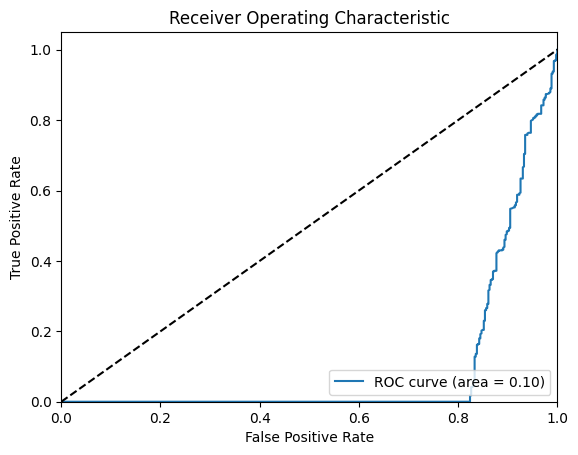

In [21]:
result = evaluate_model_with_metrics(load_model, final_df)

In [22]:
print(result)

{'FAR': [0.0, 0.2222222222222222, 0.6041666666666666, 0.7407407407407407, 0.8240740740740741, 0.8240740740740741, 0.8263888888888888, 0.8263888888888888, 0.8287037037037037, 0.8310185185185185, 0.8310185185185185, 0.8333333333333334, 0.8333333333333334, 0.8356481481481481, 0.8356481481481481, 0.8379629629629629, 0.8379629629629629, 0.8402777777777778, 0.8402777777777778, 0.8425925925925926, 0.8425925925925926, 0.8449074074074074, 0.8449074074074074, 0.8472222222222222, 0.8472222222222222, 0.8495370370370371, 0.8518518518518519, 0.8518518518518519, 0.8541666666666666, 0.8541666666666666, 0.8564814814814815, 0.8564814814814815, 0.8587962962962963, 0.8587962962962963, 0.8611111111111112, 0.8611111111111112, 0.8634259259259259, 0.8634259259259259, 0.8657407407407407, 0.8657407407407407, 0.8680555555555556, 0.8680555555555556, 0.8703703703703703, 0.8703703703703703, 0.8726851851851852, 0.8726851851851852, 0.8773148148148148, 0.8773148148148148, 0.8796296296296297, 0.8796296296296297, 0.8819

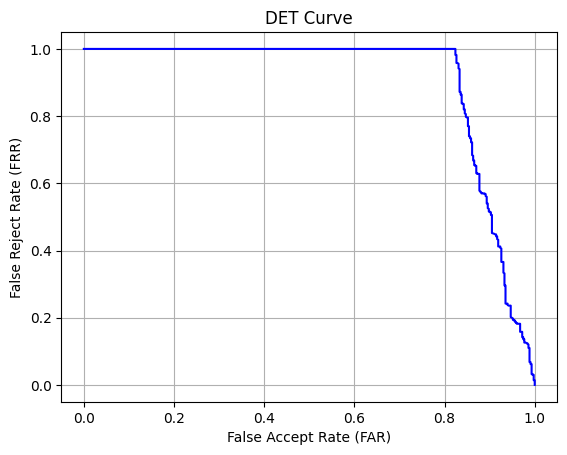

In [23]:
from sklearn.metrics import det_curve
import matplotlib.pyplot as plt

# Extract FAR (False Accept Rate) and FRR (False Reject Rate) from the results
fars = result["FAR"]
frrs = result["FRR"]

# Plotting the DET curve
plt.figure()
plt.plot(fars, frrs,linestyle='-', color='b')
plt.title('DET Curve')
plt.xlabel('False Accept Rate (FAR)')
plt.ylabel('False Reject Rate (FRR)')
plt.grid(True)
plt.show()
